## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import glob
import matplotlib as plt
from collections import OrderedDict
import random

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
from sklearn.model_selection import train_test_split


from Utils import *

##   Loading  Data

In [2]:
num_subj = 8
threshold = 20
loaded_data,load_labels = load_data(subject_count=num_subj)

Subject 8: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


### Bandpass filter

In [3]:
import numpy as np
from scipy import signal


alpha_band = [1, 40]
sampling_rate = 500
nyquist_freq = 0.5 * sampling_rate  # Nyquist frequency
low = alpha_band[0] / nyquist_freq
high = alpha_band[1] / nyquist_freq
order = 4  # Filter order



# Apply the bandpass filter to the EEG data


filtered_data_dic = {}
for i in range(8):
    df = pd.DataFrame()
    for j in loaded_data[0].columns:

        data_subj = loaded_data[i][f"{j}"]
        b, a = signal.butter(order, [low, high], btype='band')
        filtered_data_subject = signal.filtfilt(b, a, data_subj)
        df[f"{j}"] = filtered_data_subject
    filtered_data_dic[f"{i}"] = df

## Data preprocessing

In [4]:
processed_labels = process_load_labels(load_labels,num_subj)

beg_end = []
for data in processed_labels:
    val = start_end_data_finder(data)
    beg_end.append(val)

start_end_data = process_start_end(start_end = beg_end, threshold=threshold)
all_extracted_data = []
for i in range(len(start_end_data)):
    extracted_data = data_extractor(start_end_data[i],filtered_data_dic[f"{i}"])
    all_extracted_data.append(extracted_data)

In [5]:
class_data, summed_data = calculate_class_data(all_extracted_data)
combined_dict = calculate_combined_dict(class_data)
print_class_summary(combined_dict)
min_length = calculate_min_length(summed_data)
print(f"Minimum Length: {min_length}")

Class 0: Data points = 2080
Class 1: Data points = 1845
Class 2: Data points = 1174
Class 3: Data points = 2067
Class 4: Data points = 1831
Class 5: Data points = 1831
Minimum Length: 1174


In [17]:
no_events_data_extracted = []
for idx, subj_data in enumerate(loaded_data):
    no_event = data_extractor_noevent(subj_data, load_labels[idx], min_length//8,threshold = threshold)
    no_events_data_extracted.append(no_event)
class_labels = np.ones(min_length*6)

for i in range(6):
    class_labels[i*min_length:(i+1)*min_length] = class_labels[i*min_length:(i+1)*min_length] *(i)

noevent_label = np.ones(min_length)*(6)

all_class_labels = np.concatenate((class_labels,noevent_label))


import math

# Shuffle and concatenate data from combined_data
selected_data = []
for class_data in summed_data:
    selected_data.extend(class_data[:min_length+1])

# Shuffle and concatenate data from no_events_data_extracted
for arr in no_events_data_extracted:
    selected_data.extend(arr)

for i in range(len(selected_data)):    
    if len(selected_data[i]) != threshold+1:
        print(len(selected_data[i]))

selected_data = np.array(selected_data)
selected_data = np.reshape(np.array(selected_data),(selected_data.shape[0],selected_data.shape[1]*selected_data.shape[2]))

all_class_labels = all_class_labels[:selected_data.shape[0]]

print("selected_data shape:", selected_data.shape)
print("labels shape:", all_class_labels.shape)
print("selected_data data type:", selected_data.dtype)
print("labels data type:", all_class_labels.dtype)

selected_data shape: (8217, 672)
labels shape: (8217,)
selected_data data type: float64
labels data type: float64


### One-Hot encoding

In [18]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder



# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape the class_labels into a 2D array
all_class_labels = np.array(all_class_labels).reshape(-1, 1)

# Fit and transform the encoder on the class labels
one_hot_labels = encoder.fit_transform(all_class_labels)

# Print the one-hot encoded labels
print(one_hot_labels)


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


C:\Users\amoha\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Scaling and Shuffling

In [19]:
from sklearn.preprocessing import StandardScaler
all_data_shuffled , all_labels_shuffled = shuffle(selected_data, one_hot_labels, random_state = 0)


ss = StandardScaler()
all_data_shuffled_scaled = ss.fit_transform(all_data_shuffled)


In [20]:
all_data_shuffled_scaled = np.reshape(all_data_shuffled_scaled,(all_data_shuffled_scaled.shape[0],threshold+1,32))

## ResNet 

In [23]:

from tensorflow.keras.layers import  Input

num_classes = 7
# Assuming you have reshaped your selected_data
n_channels = all_data_shuffled_scaled.shape[1]
n_timepoints = all_data_shuffled_scaled.shape[2]


# Create the ResNet-like model (reuse the create_resnet function from previous answer)
resnet_model = create_resnet((n_channels, n_timepoints))

# Combine the models using the functional API
combined_input = Input(shape=(n_channels, n_timepoints))
resnet_output = resnet_model(combined_input)
# Create the final model that combines both CNN and ResNet-like models

# Split your data and train the final model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(all_data_shuffled_scaled, all_labels_shuffled, test_size=0.2, random_state=42)
resnet_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
103/103 [==============================] - 8s 24ms/step - loss: 1.6091 - accuracy: 0.2802 - val_loss: 1.5218 - val_accuracy: 0.3066
Epoch 2/50
103/103 [==============================] - 2s 21ms/step - loss: 1.5554 - accuracy: 0.2894 - val_loss: 1.5294 - val_accuracy: 0.3090
Epoch 3/50
103/103 [==============================] - 2s 23ms/step - loss: 1.5484 - accuracy: 0.2977 - val_loss: 1.5199 - val_accuracy: 0.2987
Epoch 4/50
103/103 [==============================] - 2s 22ms/step - loss: 1.5503 - accuracy: 0.3018 - val_loss: 1.5174 - val_accuracy: 0.3023
Epoch 5/50
103/103 [==============================] - 2s 19ms/step - loss: 1.5439 - accuracy: 0.3085 - val_loss: 1.5148 - val_accuracy: 0.3224
Epoch 6/50
103/103 [==============================] - 2s 18ms/step - loss: 1.5448 - accuracy: 0.3070 - val_loss: 1.5274 - val_accuracy: 0.2920
Epoch 7/50
103/103 [==============================] - 2s 19ms/step - loss: 1.5411 - accuracy: 0.3126 - val_loss: 1.5455 - val_accuracy: 0.3151

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have reshaped your selected_data

n_channels = all_data_shuffled_scaled.shape[1]
n_timepoints = all_data_shuffled_scaled.shape[2]



model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(n_channels, n_timepoints)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_channels, n_timepoints)))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

X_train, X_test, y_train, y_test = train_test_split(all_data_shuffled_scaled, all_labels_shuffled, test_size=0.2, random_state=42)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 19, 32)            3104      
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 6, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_19 (Conv1D)          (None, 4, 64)             6208      
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_50 (Flatten)        (None, 64)                0         
                                                                 
 dense_52 (Dense)            (None, 128)             

### Dimentionality reduction

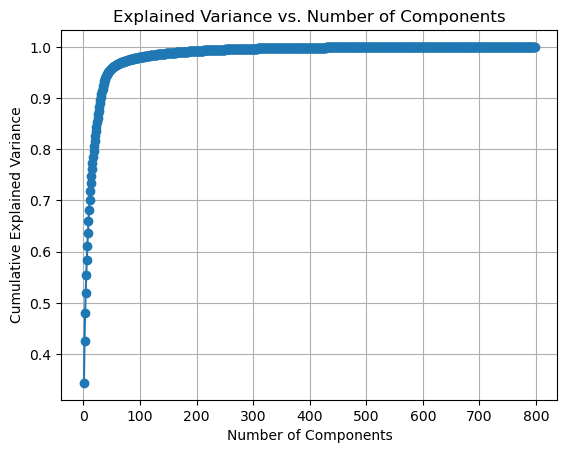

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(all_data_shuffled_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [ ]:
n_components = 100
pca = PCA(n_components = n_components)
pca.fit(all_data_shuffled)
pca_tr = pca.fit_transform(all_data_shuffled_scaled)

## Model Analysis

#### Support Vector machines

In [ ]:
all_data_shuffled_scaled.shape

(8217, 21, 32)

In [ ]:
all_data_shuffled_scaled = np.reshape(all_data_shuffled_scaled,(all_data_shuffled_scaled.shape[0],all_data_shuffled_scaled.shape[1]*all_data_shuffled_scaled.shape[2]))

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel="rbf")
evaluate_model(model, all_data_shuffled_scaled, all_labels_shuffled)

ValueError: y should be a 1d array, got an array of shape (6573, 7) instead.

C:\Users\amoha\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.3248175182481752


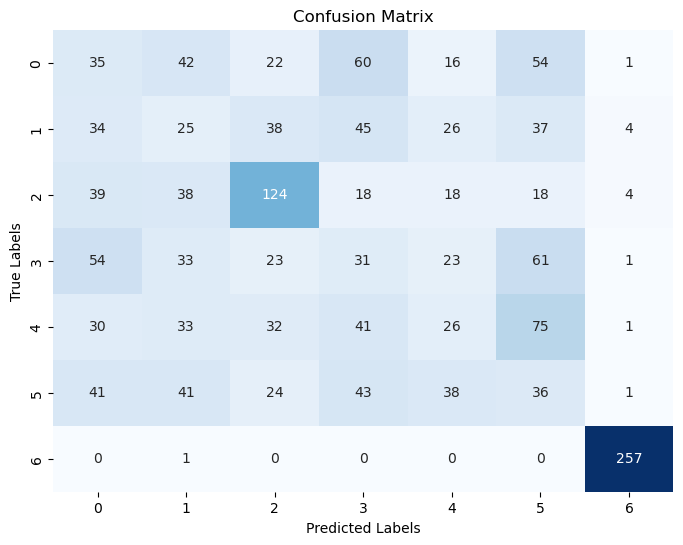

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
model = SVC(kernel="rbf")
evaluate_model(model, pca_tr,  all_labels_shuffeled_not_onehot)

#### Random Forest Model


Accuracy: 0.9629080118694362


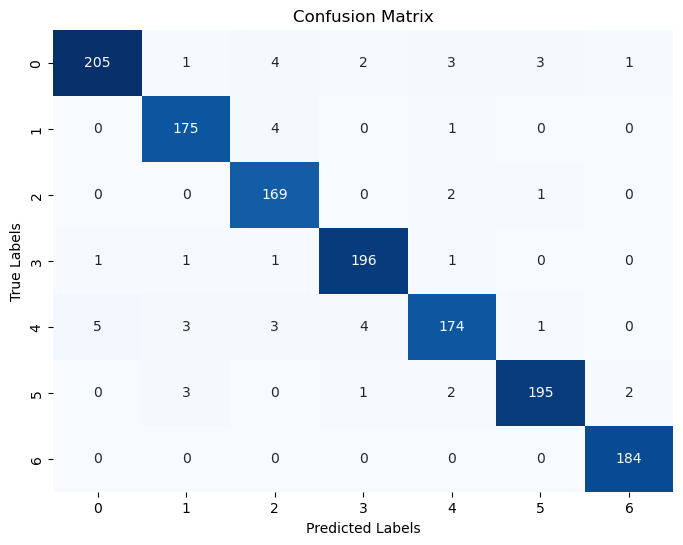

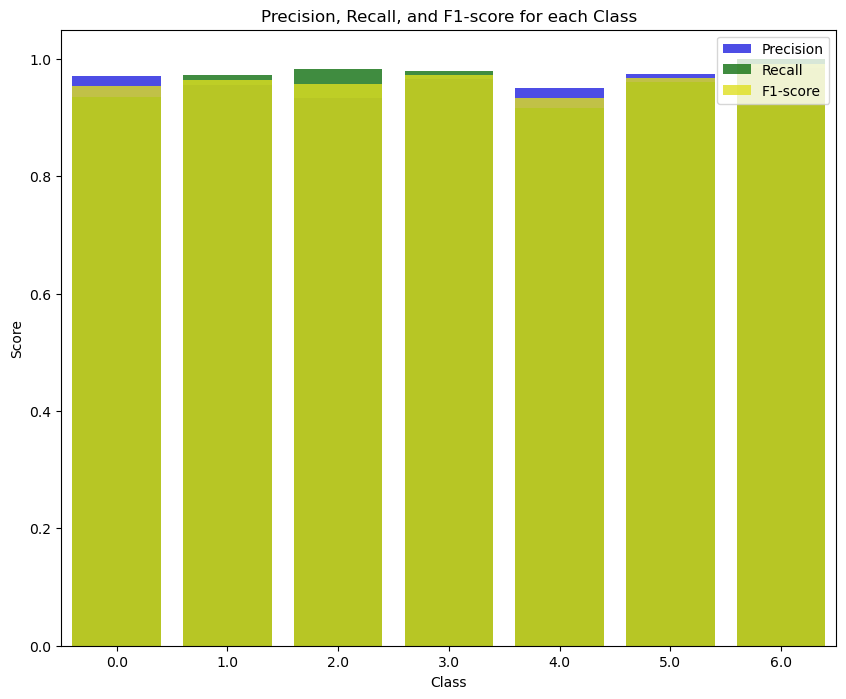

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       219
         1.0       0.96      0.97      0.96       180
         2.0       0.93      0.98      0.96       172
         3.0       0.97      0.98      0.97       200
         4.0       0.95      0.92      0.93       190
         5.0       0.97      0.96      0.97       203
         6.0       0.98      1.00      0.99       184

    accuracy                           0.96      1348
   macro avg       0.96      0.96      0.96      1348
weighted avg       0.96      0.96      0.96      1348



In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### K nearest neighbor
**n_neighbors** : A common heuristic is to use the square root of the number of data points in the dataset as the k-value. fo this case k=√3000 ≈ 54.

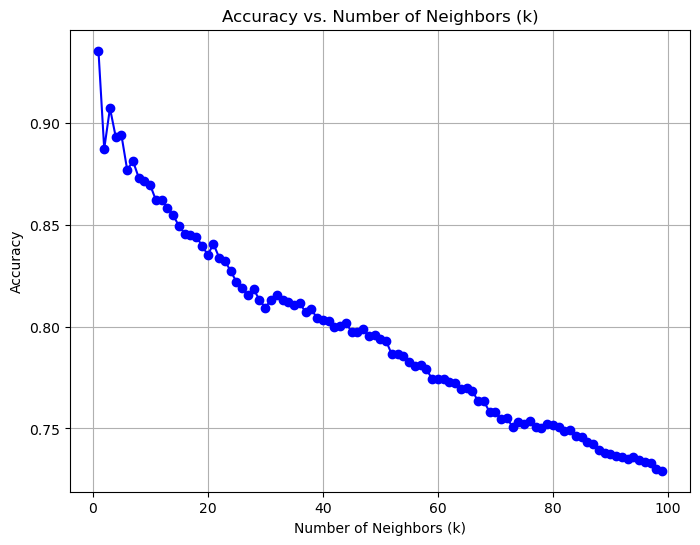

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_tr, all_labels_shuffled, test_size=0.2, random_state=42)

# Initialize lists to store accuracy scores for different k values
k_values = list(range(1, 100))
accuracy_scores = []

# Loop through different k values
for k in k_values:
    # Create and fit the k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the accuracy scores for different k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()


Accuracy: 0.8731454005934718


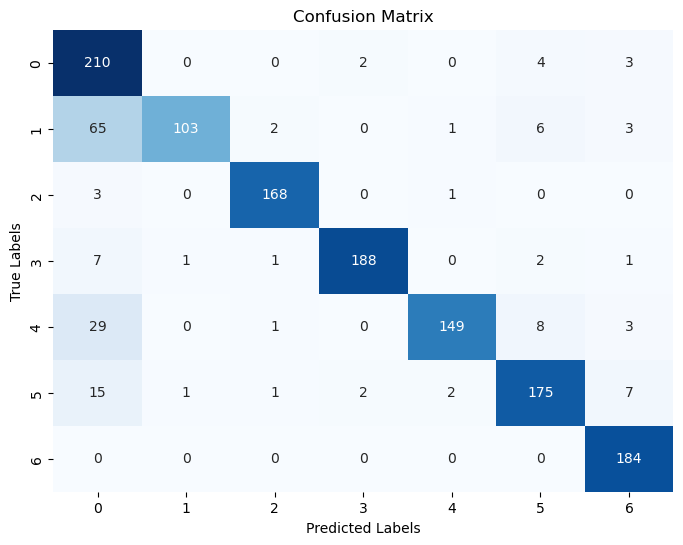

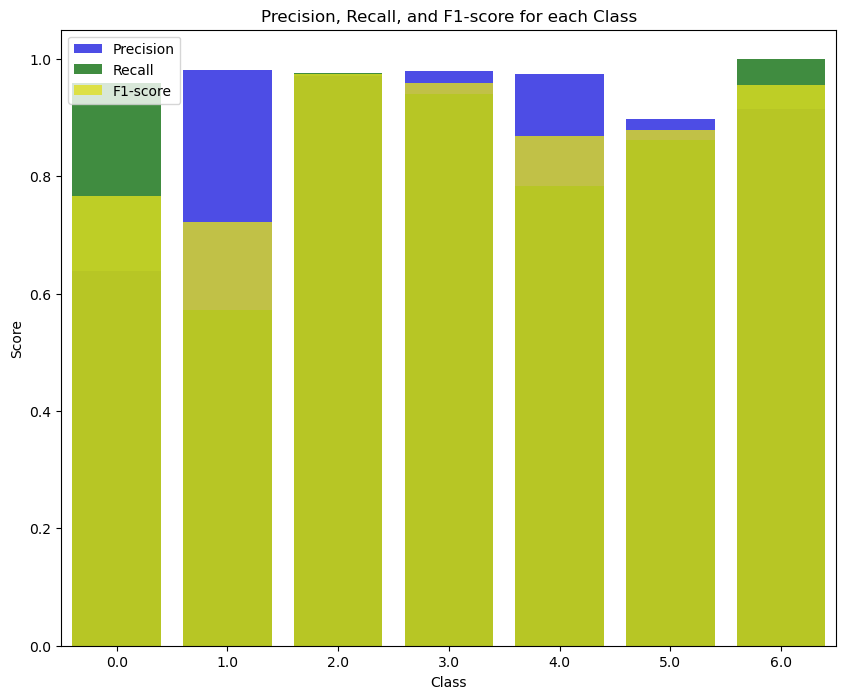

Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.96      0.77       219
         1.0       0.98      0.57      0.72       180
         2.0       0.97      0.98      0.97       172
         3.0       0.98      0.94      0.96       200
         4.0       0.97      0.78      0.87       190
         5.0       0.90      0.86      0.88       203
         6.0       0.92      1.00      0.96       184

    accuracy                           0.87      1348
   macro avg       0.91      0.87      0.88      1348
weighted avg       0.90      0.87      0.87      1348



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors = 8)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### XGBoost

Accuracy: 0.9428783382789317


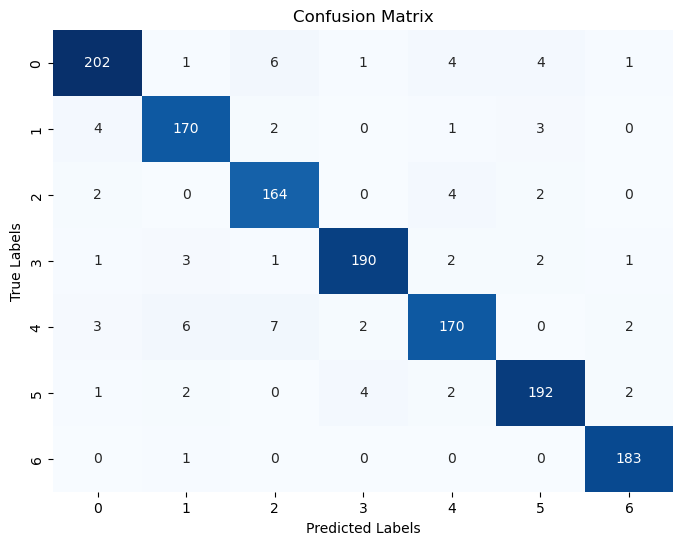

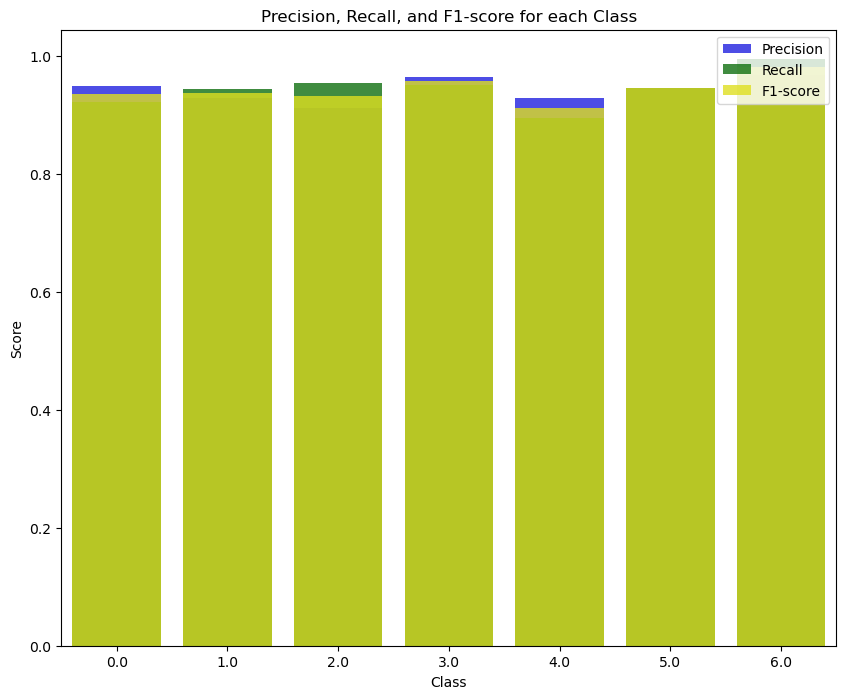

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       219
         1.0       0.93      0.94      0.94       180
         2.0       0.91      0.95      0.93       172
         3.0       0.96      0.95      0.96       200
         4.0       0.93      0.89      0.91       190
         5.0       0.95      0.95      0.95       203
         6.0       0.97      0.99      0.98       184

    accuracy                           0.94      1348
   macro avg       0.94      0.94      0.94      1348
weighted avg       0.94      0.94      0.94      1348



In [ ]:
import xgboost as xgb
params = {
    'objective': 'multi:softmax',  # Multi-class classification objective
    'num_class': 7,                # Number of classes in the multi-class problem
    'eval_metric': 'mlogloss',     # Multiclass Logarithmic Loss
    'eta': 0.1,                    # Learning rate
    'max_depth': 3,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of columns when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

xgb_model = xgb.XGBClassifier(**params)
evaluate_model(xgb_model, pca_tr, all_labels_shuffled)

In [ ]:
test_Data,test_labels = load_data(subject_count=8)

Subject 8: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


In [ ]:
subj78data={}
subj78data["7"] =  test_Data[6]
subj78data["8"] = test_Data[7]
subj78label = {}
subj78label["7"] =  test_labels[6]
subj78label["8"] = test_labels[7]